<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Code-Development-Tests" data-toc-modified-id="Code-Development-Tests-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code Development Tests</a></span></li><li><span><a href="#Investigating-the-Mertz-Effect" data-toc-modified-id="Investigating-the-Mertz-Effect-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Investigating the Mertz Effect</a></span></li><li><span><a href="#Processing-N2-Spectra" data-toc-modified-id="Processing-N2-Spectra-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Processing N2 Spectra</a></span></li><li><span><a href="#Processing-CO2-Spectra" data-toc-modified-id="Processing-CO2-Spectra-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Processing CO2 Spectra</a></span></li><li><span><a href="#Processing-Air-Spectra" data-toc-modified-id="Processing-Air-Spectra-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Processing Air Spectra</a></span></li><li><span><a href="#Step-4:-S/N" data-toc-modified-id="Step-4:-S/N-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Step 4: S/N</a></span></li><li><span><a href="#Step-3" data-toc-modified-id="Step-3-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Step 3</a></span></li><li><span><a href="#Step-5" data-toc-modified-id="Step-5-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Step 5</a></span></li><li><span><a href="#Step-6" data-toc-modified-id="Step-6-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Step 6</a></span></li><li><span><a href="#Step-7" data-toc-modified-id="Step-7-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Step 7</a></span></li></ul></div>

In [525]:
import re
import sys
import os
#sys.path.insert(0, '../..')
#os.chdir('../../../')

import matplotlib.pyplot as plt
import numpy as np

from scipy import signal
from scipy.fftpack import fft, fftshift

%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams.update({'font.size': 22})

import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(15,6)}, font_scale=1.8)  
sns.set_style('whitegrid', {'font.family':'helvetica', 'font.serif':'Times New Roman'})
sns.set_palette("RdBu")

# Helper Functions

In [526]:
POWERS2 = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
MAX_WAVENUMBER = 15802

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

class Interferogram:
    """Interferogram class for all data processing, plotting, and saving. 


    Attributes:
        dir: directory holding data file
        filename: filename holding data
        datestamp: datestamp recording when data was taken
        res: resolution of scan
        vel: mirror velocity of scan
        LP: low pass frequency of scan
        HP: high pass frequency of scan
        gain: gain of scan
        raw_data: parsed interferogram acquisitions of scan
        num_acq: number of acquisitions of scan
        num_pts: number of points of each acquistion in scan
        wavenumbers: wavenumber axis for each acquisiton
        spectra: fourier transformed spectra with mertz correction
    """
    
    def __init__(self, DIR, filename, sampling=1):
        self.dir = DIR
        self.filename = filename
        
        with open(DIR+filename) as f:
            data = f.read().splitlines() 
        
        # Read in params at the top of the file
        self.datestamp = data[0].replace("#","").strip()
        result = re.search(r'\d+', data[1])
        self.res = int(result.group())
        result = re.search(r'\d+', data[2])
        self.vel = int(result.group())
        result = re.search(r'\d+', data[3])
        self.LP = int(result.group())
        result = re.search(r'\d+', data[4])
        self.HP = int(result.group())
        result = re.search(r'\d+', data[5])
        self.gain = int(result.group())
        
        # Read in the raw spectrum data
        raw = list(filter(None, data[6:]))
        scan_idx = [i for i in range(0, len(raw)) if "#" in raw[i]] + [len(raw)]
        self.raw_data = np.array(
            [np.array(raw[scan_idx[i]+1:scan_idx[i+1]], dtype=np.float) for i in range(0, len(scan_idx)-1)]
        )
        self.num_acq = len(self.raw_data)
        
        # Find the wavenumbers
        self.num_pts = [len(self.raw_data[i]) for i in range(0, self.num_acq)]
        self.wavenumbers = np.array(
            [sampling*np.linspace(0, MAX_WAVENUMBER, num=int(self.num_pts[i])/2) for i in range(0, self.num_acq)]
        )

        # Find the spectra
        mean = np.mean(np.array([x for x in raw if "#" not in x], dtype=np.float))
        self.spectra = self.fft(mean)

        
    def dictify(self):
        return {
            "filename": self.filename,
            "datestamp": self.datestamp,
            "resolution": self.res,
            "velocity": self.vel,
            "LP": self.LP,
            "HP": self.HP,
            "gain": self.gain
        }
    
    
    def fft(self, mean):
        """
        Calculates the spectra of the interferogram
        
        Args:
            interferogram2: The test sample spectrum, a np.array

        Returns:
            A numpy array of transmittances. 
        
        Raises:
            AssertionError: An error occurred if resolutions are different
        """
        new_data = []

        for line in self.raw_data:
            
            # Normalize data
            new_line = Interferogram.normalize_raw_data(line, mean)
            
            # Zero fill the data
            new_line = Interferogram.zero_fill(new_line)
            
            # Find the phase corrections
            phase, re_phase, im_phase = self.mertz(new_line)
            
            # fft the interferogram
            inter, re_inter, im_inter = Interferogram.fft_interferogram(line)
            
            # Record the spectra multiplied by correction
            new_data.append(np.absolute(np.multiply(inter, phase)))
        
        return np.array(new_data)
        

    def mertz(self, data):
        """
        Returns the phase correction data
        The real and imaginary data arrays are multiplied by the power spectrum 
        """
        # find burtst location
        burst = np.argmax(data)
        
        # Add the apodization triangular phase correction
        copied_burst = np.zeros(len(data))
        copied_burst[burst-128:burst+128] = data[burst-128:burst+128]
        copied_burst = np.multiply(copied_burst, Interferogram.triangular_signal(burst, len(copied_burst)))
        
        # Slicing to rotate about ZPD
        copied_burst = np.concatenate((copied_burst[burst:], copied_burst[:burst]))
        
        # data is FFT'd, producing real and imaginary data arrays.
        ffted = np.fft.fft(copied_burst)
        im_data = ffted.imag
        re_data = ffted.real
        
        # Find power spectrum
        power = np.absolute(ffted)
        
        # The real and imaginary data arrays are multiplied by the power spectrum 
        return np.multiply(power, ffted), np.multiply(re_data, power), np.multiply(im_data, power)


    @staticmethod
    def fft_interferogram(data):
        """
        Do the fft for the interferogram, including the apodization, etc. 
        """
        
        # find burst location
        burst = np.argmax(data)
        
        # Apodize the whole interferogram with triangular function
        data = np.multiply(data, Interferogram.triangular_signal(burst, len(data)))
        
        # zero fill
        data = Interferogram.zero_fill(data)
        
        # Slicing to rotate about ZPD
        data = np.concatenate((data[burst:], data[:burst]))
        
        # data is FFT'd, producing real and imaginary data arrays.
        ffted = np.fft.fft(data)
        return ffted, ffted.real, ffted.imag
    
    
    @staticmethod
    def zero_fill(data):
        """
        FFT requires number of points in the interferogram be a power of 2.
        If it is not, then the size of the array is increased to the next higher power of 2 
        and the added points are set to 0. 
        
        Args: 
            data: interferogram to be filled
        Returns: 
            A numpy array of filled interferogram
        """
        for i in range(10, len(POWERS2)):
            if POWERS2[i] >= len(data):
                break
        return np.concatenate((data, np.zeros(POWERS2[i]-len(data))))
    
    
    @staticmethod
    def normalize_raw_data(data, mean):
        """The mean of the data is subtracted from the data, brings baseline of data to 0"""
        return data - mean
    
    @staticmethod
    def apodize(burst, data):
        return np.multiply(data, Interferogram.triangular_signal(burst, len(data)))
    
    @staticmethod
    def triangular_signal(center, total_len):
        window = signal.triang(2*center-1)
        try:
            return np.concatenate((window, np.zeros(total_len-len(window))))
        except:
            return window[:total_len]
    
    @staticmethod
    def calc_transmittance(interferogram1, interferogram2):
        """
        Calculates the transmittance per wavenumber
        
        Args:
            interferogram1: The background spectrum, a np.array
            interferogram2: The test sample spectrum, a np.array

        Returns:
            A numpy array of transmittances. 
        
        Raises:
            AssertionError: An error occurred if resolutions are different
        """
        assert (len(interferogram1) == len(interferogram2)), 'Background spectrum has {} pts, sample spectrum has {} pts'.format(len(interferogram1), len(interferogram2))
        return np.divide(interferogram2, interferogram1)
    
        
    @staticmethod
    def calc_absorbance(transmittance):
        """
        Calculates the absorbance per wavenumber
        
        Args:
            transmittance: array of transmittances

        Returns:
            A numpy array of absorbances. 
        """
        return -np.log(transmittance)
    
    @staticmethod
    def calc_snr(interferogram1, interferogram2):
        """
        Calculates the signal to noise ratio
        
        Args:
            interferogram1: The background spectrum, a np.array
            interferogram2: The test sample spectrum, a np.array

        Returns:
            A signal to noise value
        """
        transmittance = Interferogram.calc_transmittance(interferogram1, interferogram2)
        noise_rms = np.sqrt(np.mean(np.square(transmittance)))
        return 100 / noise_rms       

# Code Development Tests

In [527]:
DIR = "week1/"

In [528]:
#filename = "week1_step5_n2_flush.txt"
filename = "week1_centering.txt"
curr = Interferogram(DIR, filename)

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


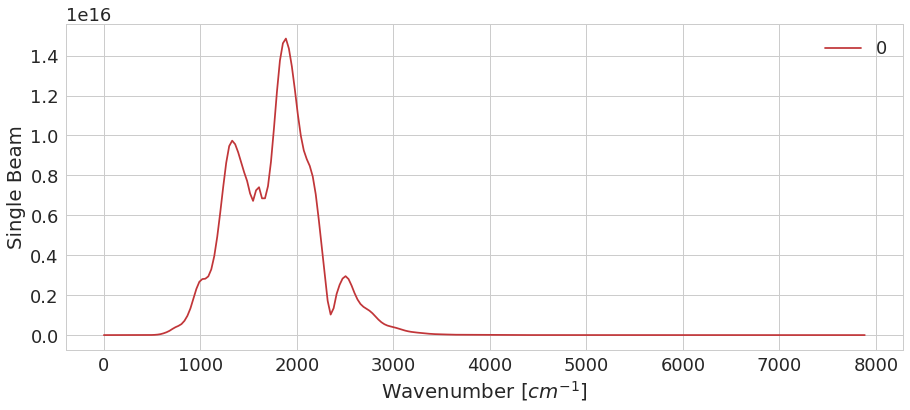

In [529]:
# The FT'd result
plt.figure()
ind = int(len(curr.wavenumbers[0])/2)
for i in range(0, 1):
    plt.plot(curr.wavenumbers[i][:ind], curr.spectra[i][:ind], label=str(i))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Single Beam")
#plt.title("Processed FFT'd Interferogram")
plt.legend()
plt.show()

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


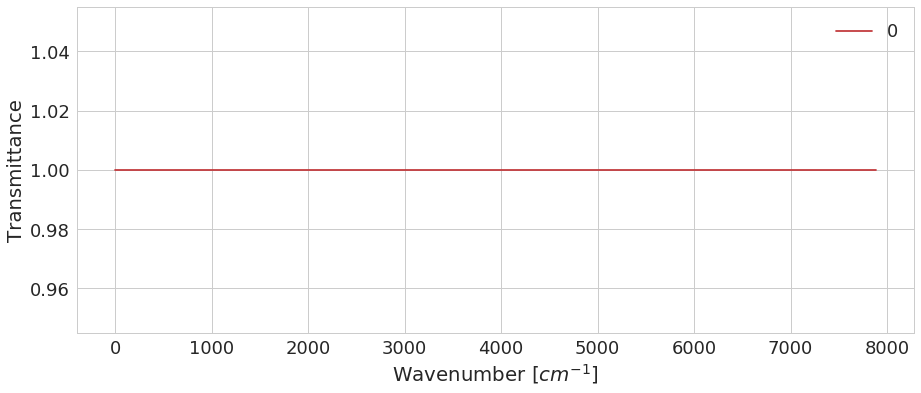

In [530]:
plt.figure()
ind = int(len(curr.wavenumbers[0])/2)
for i in range(0, curr.num_acq):
    plt.plot(curr.wavenumbers[i][:ind], Interferogram.calc_transmittance(curr.spectra[0][:ind], curr.spectra[0][:ind]), label=str(i))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Transmittance")
plt.legend()
plt.show()

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


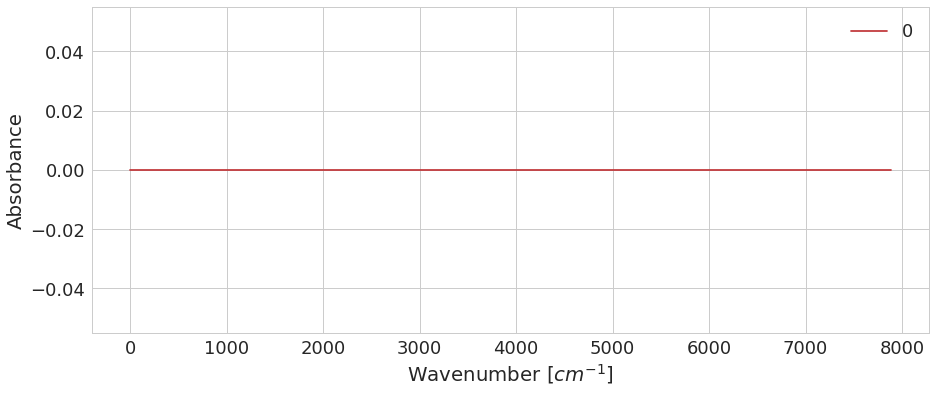

In [531]:
plt.figure()
for i in range(0, curr.num_acq):
    plt.plot(curr.wavenumbers[i][:ind], Interferogram.calc_absorbance(Interferogram.calc_transmittance(curr.spectra[0][:ind], curr.spectra[0][:ind])), label=str(i))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Absorbance")
plt.legend()
plt.show()

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


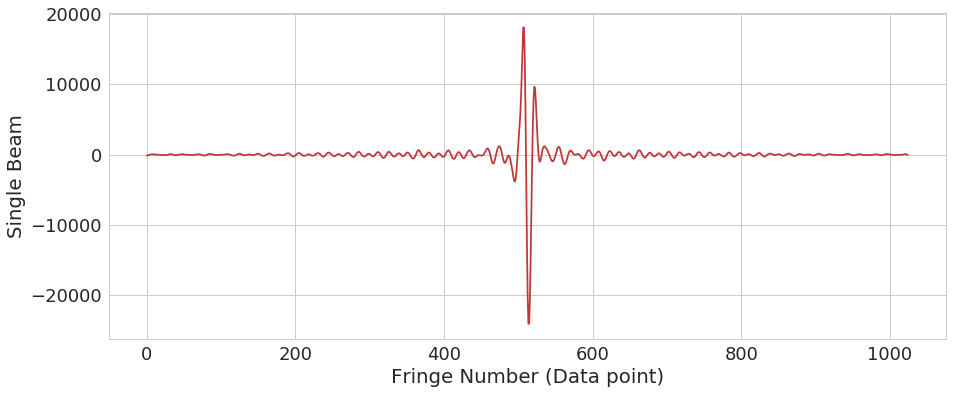

In [532]:
# Raw data interferogram
plt.figure()
for i in range(0, curr.num_acq):
    plt.plot(np.linspace(0, curr.num_pts[i], num=curr.num_pts[i]), curr.raw_data[i], label=str(i))
plt.grid(True)
plt.xlabel("Fringe Number (Data point)")
plt.ylabel("Single Beam")
#plt.title("Interferogram")
#plt.legend()
plt.show()

# Investigating the Mertz Effect

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


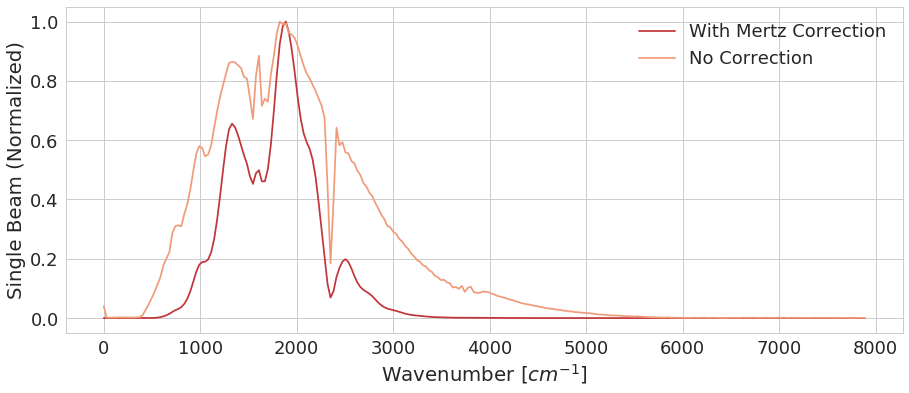

In [533]:
# The FT'd result
plt.figure()
ind = int(len(curr.wavenumbers[0])/2)
plt.plot(curr.wavenumbers[0][:ind], curr.spectra[0][:ind]/np.max(curr.spectra[0]), label="With Mertz Correction")
plt.plot(curr.wavenumbers[0][:ind], np.absolute(np.fft.fft(curr.raw_data[0]))[:ind]/np.max(np.absolute(np.fft.fft(curr.raw_data[0]))), label="No Correction")
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Single Beam (Normalized)")
#plt.title("FFT'd Interferogram With and Without Correction (Oversampling)")
plt.legend()
plt.show()

# Processing N2 Spectra


In [534]:
DIR = "week2/"
filename = "Step 5/n2_cell_4cm-1 (1 ac).txt"
n2 = Interferogram(DIR, filename)

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


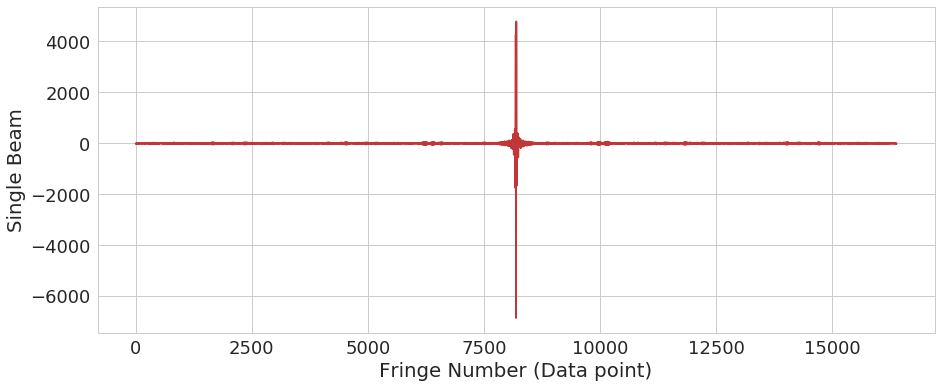

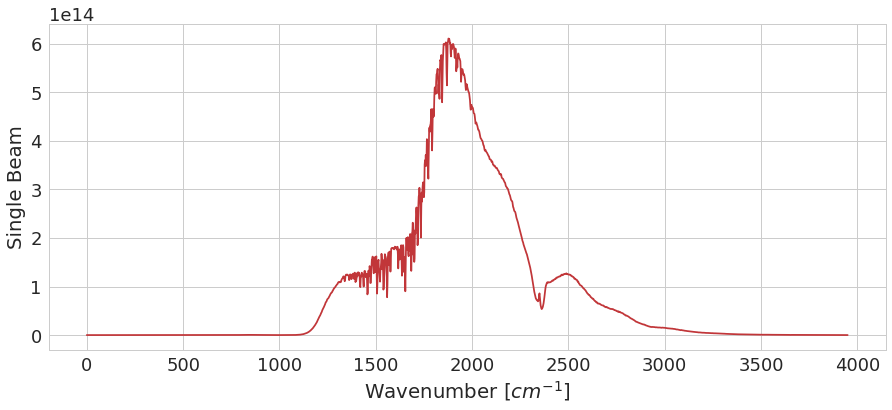

In [535]:
# Raw data interferogram
plt.figure()
plt.plot(np.linspace(0, n2.num_pts[0], num=n2.num_pts[0]), n2.raw_data[0])
plt.grid(True)
plt.xlabel("Fringe Number (Data point)")
plt.ylabel("Single Beam")
#plt.title("N2 Interferogram")
plt.show()

# The FT'd result
plt.figure()
ind = int(len(n2.wavenumbers[0])/4)
plt.plot(n2.wavenumbers[0][:ind], n2.spectra[0][:ind])
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Single Beam")
#plt.title("N2 Spectra")
plt.show()

# Processing CO2 Spectra

In [536]:
DIR = "week2/"
filename = "Step 6/co2_cell_4cm-1 (3min).txt"
co2 = Interferogram(DIR, filename)

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


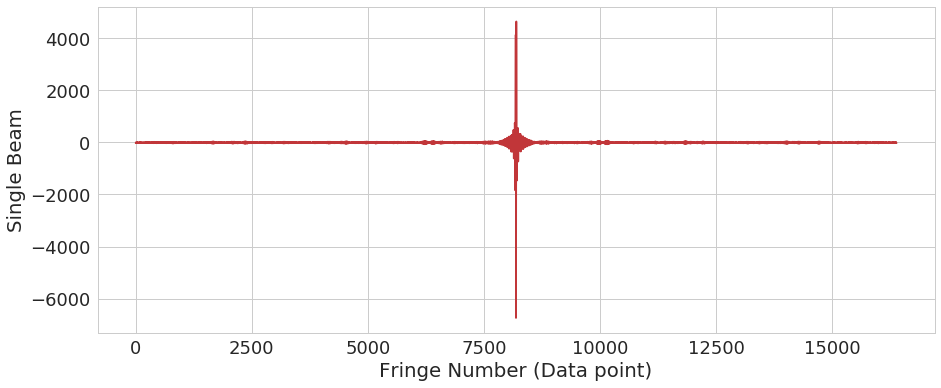

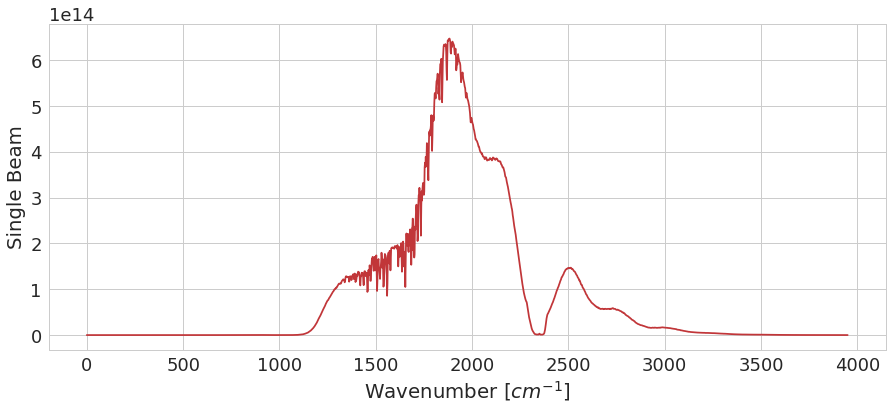

In [537]:
# Raw data interferogram
plt.figure()
plt.plot(np.linspace(0, co2.num_pts[0], num=co2.num_pts[0]), co2.raw_data[0])
plt.grid(True)
plt.xlabel("Fringe Number (Data point)")
plt.ylabel("Single Beam")
#plt.title("N2 Interferogram")
plt.show()

# The FT'd result
plt.figure()
ind = int(len(co2.wavenumbers[0])/4)
plt.plot(co2.wavenumbers[0][:ind], co2.spectra[0][:ind])
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Single Beam")
#plt.title("N2 Spectra")
plt.show()

No handles with labels found to put in legend.
/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


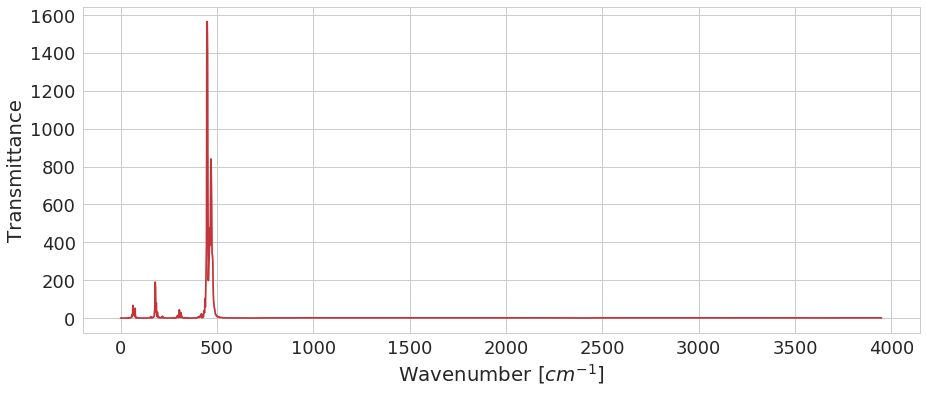

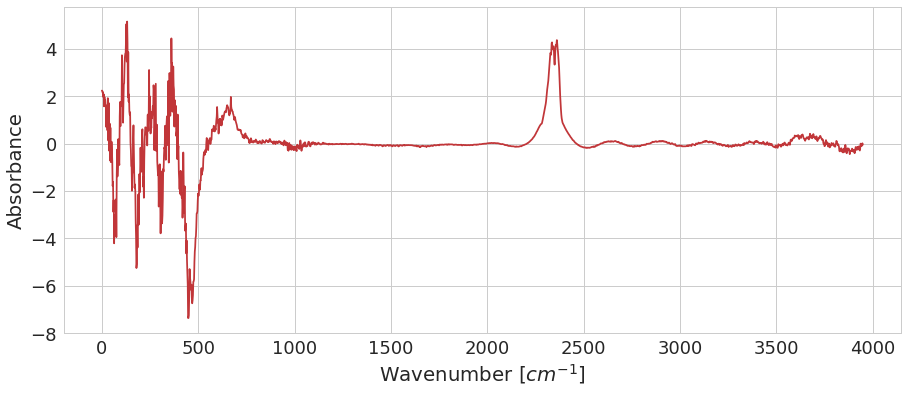

In [538]:
# Transmittance
plt.figure()
i=0
plt.plot(n2.wavenumbers[i][:ind], Interferogram.calc_transmittance(n2.spectra[0][:ind], co2.spectra[0][:ind]))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Transmittance")
plt.legend()
plt.show()

# Absorbance
plt.figure()
i=0
plt.plot(n2.wavenumbers[i][:ind], Interferogram.calc_absorbance(Interferogram.calc_transmittance(n2.spectra[0][:ind], co2.spectra[0][:ind])))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Absorbance")
plt.show()

# Processing Air Spectra

In [539]:
DIR = "week2/"
filename = "Step 7/air_cell_4cm-1.txt"
air = Interferogram(DIR, filename)

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


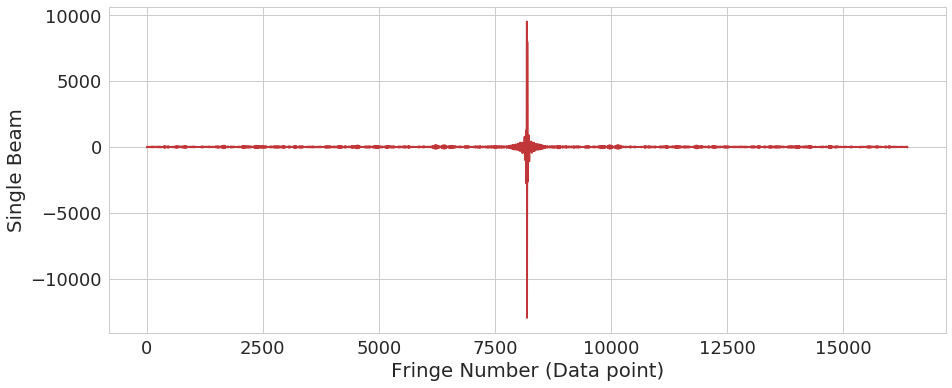

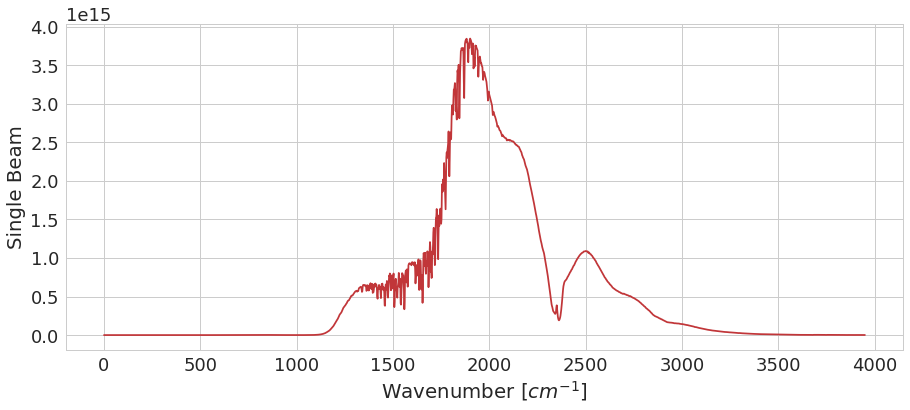

In [540]:
# Raw data interferogram
plt.figure()
plt.plot(np.linspace(0, air.num_pts[0], num=air.num_pts[0]), air.raw_data[0])
plt.grid(True)
plt.xlabel("Fringe Number (Data point)")
plt.ylabel("Single Beam")
#plt.title("N2 Interferogram")
plt.show()

# The FT'd result
plt.figure()
ind = int(len(air.wavenumbers[0])/4)
plt.plot(air.wavenumbers[0][:ind], air.spectra[0][:ind])
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Single Beam")
#plt.title("N2 Spectra")
plt.show()

No handles with labels found to put in legend.
/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


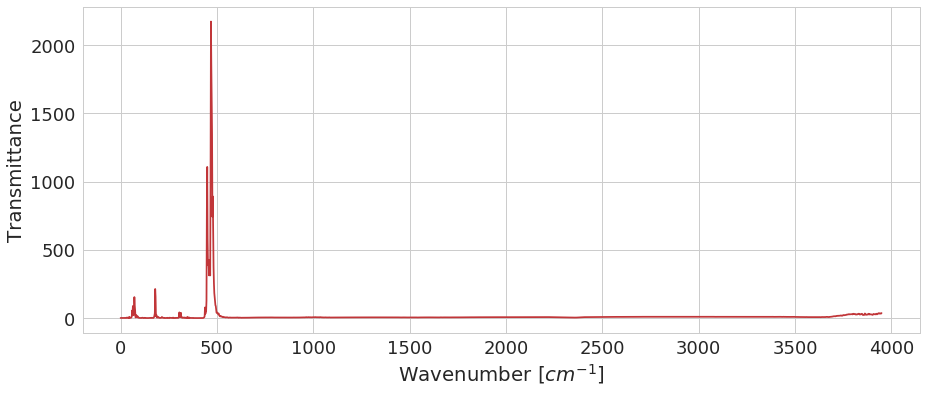

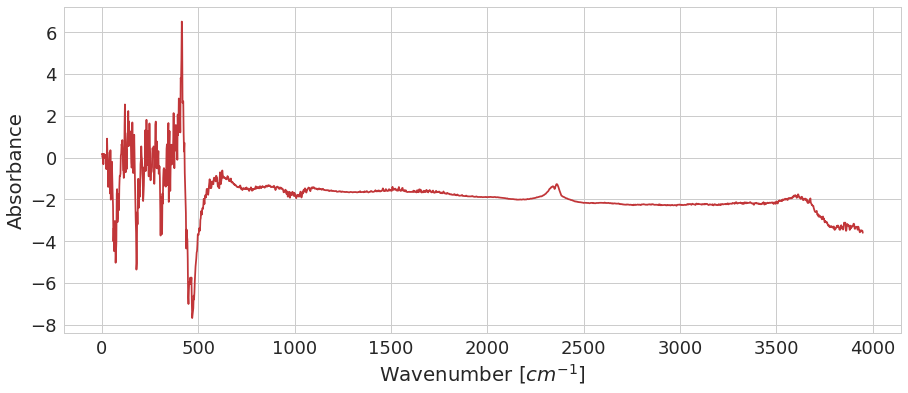

In [541]:
# Transmittance
plt.figure()
i=0
plt.plot(n2.wavenumbers[i][:ind], Interferogram.calc_transmittance(n2.spectra[0][:ind], air.spectra[0][:ind]))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Transmittance")
plt.legend()
plt.show()

# Absorbance
plt.figure()
i=0
plt.plot(n2.wavenumbers[i][:ind], Interferogram.calc_absorbance(Interferogram.calc_transmittance(n2.spectra[0][:ind], air.spectra[0][:ind])))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Absorbance")
plt.show()

# Step 4: S/N

In [542]:
DIR = "week2/"
filename=["week2_step4_snr_res_4.txt", "week2_step4_snr_res_16.txt"]
res = [Interferogram(DIR, filename[i]) for i in range(0, 2)]

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


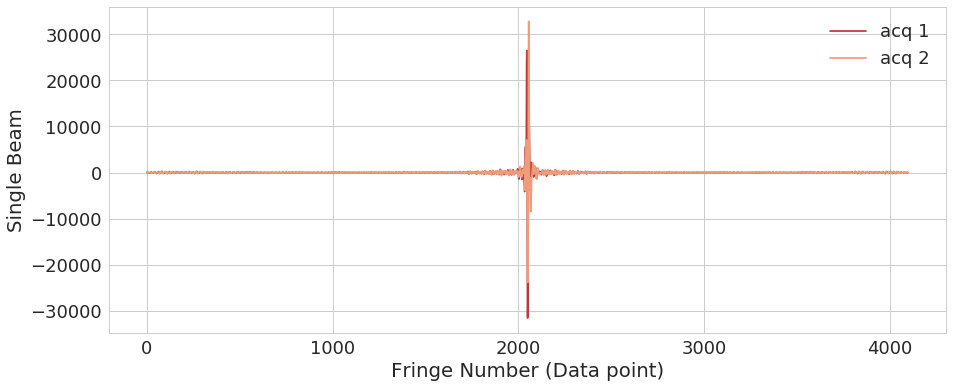

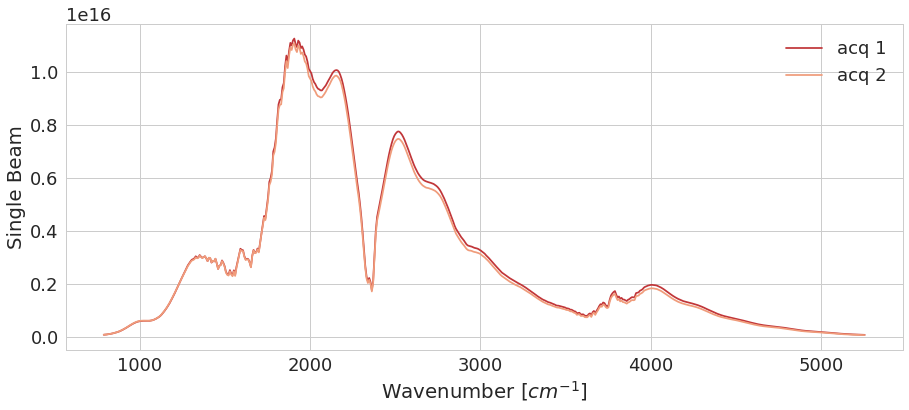

No handles with labels found to put in legend.


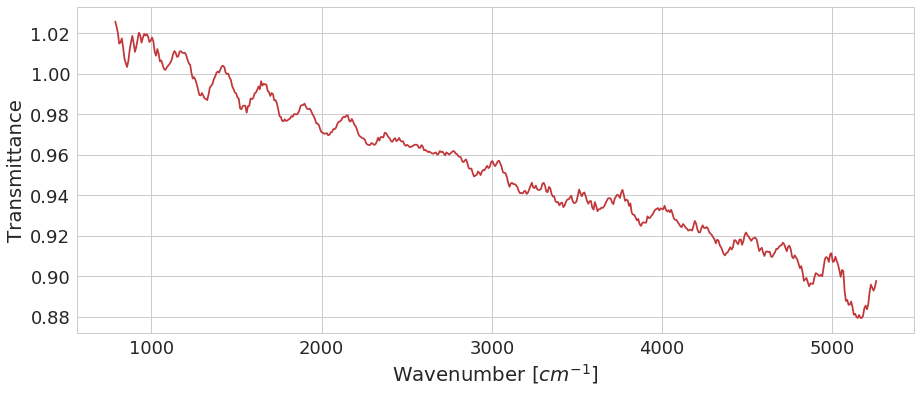

The signal to noise ratio for week2_step4_snr_res_16.txt is: 104.927




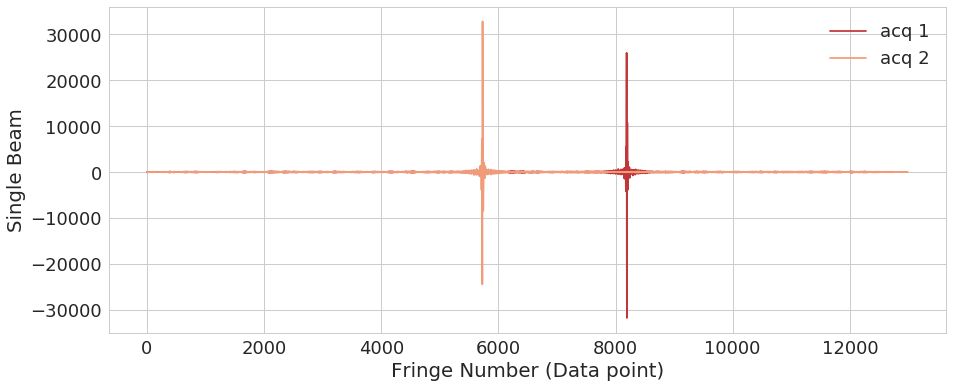

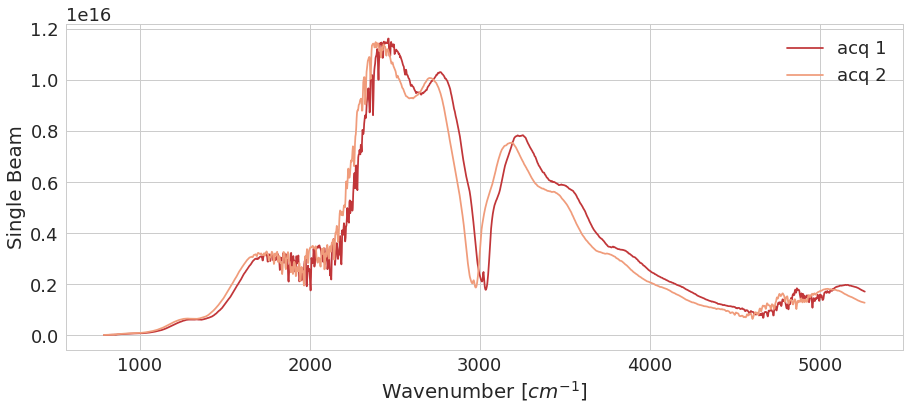

No handles with labels found to put in legend.


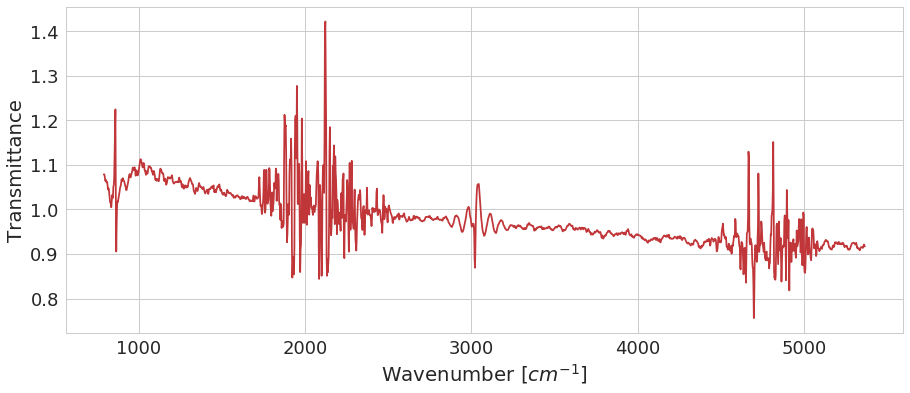

The signal to noise ratio for week2_step4_snr_res_4.txt is: 101.811




In [543]:
# Raw data interferogram resolution 4cm, both acquisitions
for i in range(1, -1, -1):
    res4 = res[i]
    plt.figure()
    plt.plot(np.linspace(0, res4.num_pts[0], num=res4.num_pts[0]), res4.raw_data[0], label=r"acq 1")
    plt.plot(np.linspace(0, res4.num_pts[1], num=res4.num_pts[1]), res4.raw_data[1], label=r"acq 2")
    plt.grid(True)
    plt.xlabel("Fringe Number (Data point)")
    plt.ylabel("Single Beam")
    plt.legend()
    plt.show()

    # The FT'd result
    plt.figure()
    ind = int(len(res4.wavenumbers[0])/3)
    lind = int(len(res4.wavenumbers[0])/20)
    plt.plot(res4.wavenumbers[0][lind:ind], res4.spectra[0][lind:ind], label=r"acq 1")
    ind = int(len(res4.wavenumbers[1])/3)
    lind = int(len(res4.wavenumbers[1])/20)
    plt.plot(res4.wavenumbers[1][lind:ind], res4.spectra[1][lind:ind], label=r"acq 2")
    plt.grid(True)
    plt.xlabel(r"Wavenumber [$cm^{-1}$]")
    plt.ylabel("Single Beam")
    plt.legend()
    plt.show()

    # Transmittance
    plt.figure()
    ind = max(int(len(res4.wavenumbers[0])/3), int(len(res4.wavenumbers[1])/3))
    lind = min(int(len(res4.wavenumbers[0])/20), int(len(res4.wavenumbers[1])/20))
    plt.plot(res4.wavenumbers[0][lind:ind], Interferogram.calc_transmittance(res4.spectra[0][lind:ind], res4.spectra[1][lind:ind]))
    plt.grid(True)
    plt.xlabel(r"Wavenumber [$cm^{-1}$]")
    plt.ylabel("Transmittance")
    plt.legend()
    plt.show()

    # Find the S/N ratio
    print("The signal to noise ratio for %s is: %.3f" % (res4.filename, Interferogram.calc_snr(res4.spectra[0][lind:ind], res4.spectra[1][lind:ind])))
    print()
    print()

# Step 3

In [544]:
DIR = "week1/"
filename = ["week1_step3_n2_10mins.txt", "week1_step3_n2_20mins.txt"]
mins = [Interferogram(DIR, filename[i]) for i in range(0, len(filename))]

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


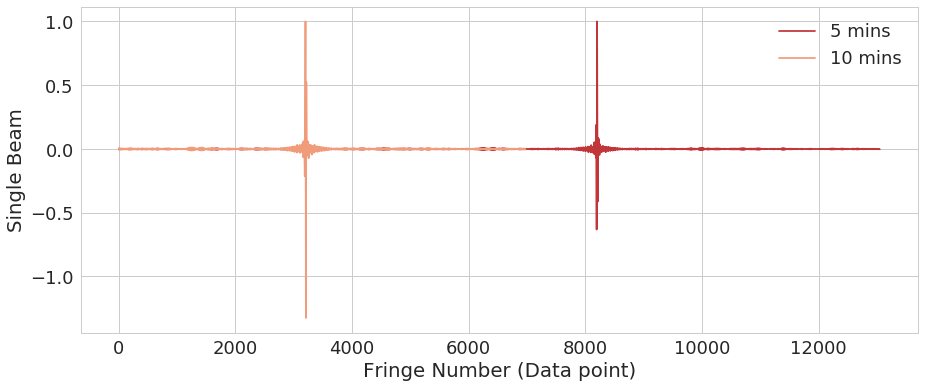

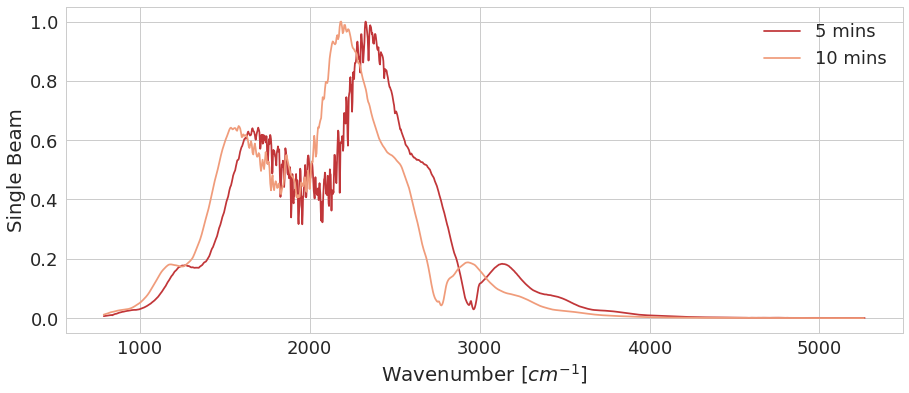

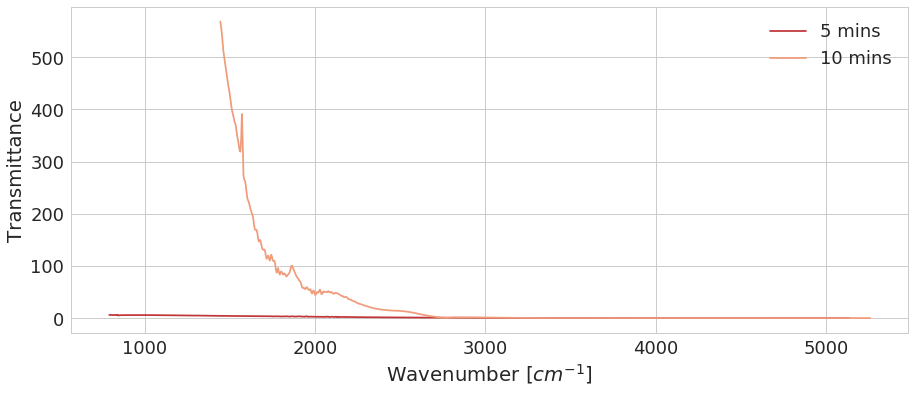

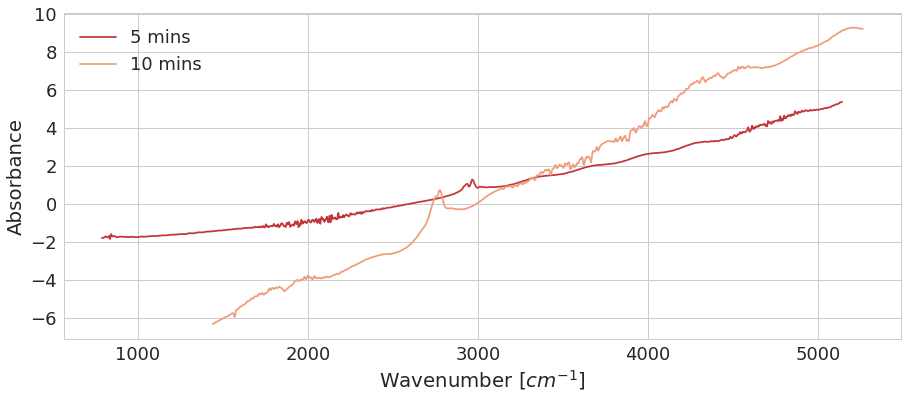

In [545]:
# Raw data interferogram resolution 4cm, both acquisitions
plt.figure()
i = 8
j = 5
plt.plot(np.linspace(0, mins[0].num_pts[j], num=mins[0].num_pts[j]), mins[0].raw_data[j]/max(mins[0].raw_data[j]), label=r"5 mins")
plt.plot(np.linspace(0, mins[1].num_pts[i], num=mins[1].num_pts[i]), mins[1].raw_data[i]/max(mins[1].raw_data[i]), label=r"10 mins")
plt.grid(True)
plt.xlabel("Fringe Number (Data point)")
plt.ylabel("Single Beam")
plt.legend()
plt.show()

# The FT'd result
plt.figure()
ind = int(len(mins[0].wavenumbers[j])/3)
lind = int(len(mins[0].wavenumbers[j])/20)
plt.plot(mins[0].wavenumbers[j][lind:ind], mins[0].spectra[j][lind:ind]/max(mins[0].spectra[j][lind:ind]), label=r"5 mins")

ind = int(len(mins[1].wavenumbers[i])/3)
lind = int(len(mins[1].wavenumbers[i])/20)
plt.plot(mins[1].wavenumbers[i][lind:ind], mins[1].spectra[i][lind:ind]/max(mins[1].spectra[i][lind:ind]), label=r"10 mins")
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Single Beam")
plt.legend()
plt.show()

# Transmittance
plt.figure()
ind = min(int(len(mins[0].wavenumbers[j])/3), int(len(res4.wavenumbers[0])/3))
lind = max(int(len(mins[0].wavenumbers[j])/20), int(len(res4.wavenumbers[0])/20))
plt.plot(mins[0].wavenumbers[j][lind:ind], Interferogram.calc_transmittance(res4.spectra[0][lind:ind], mins[0].spectra[j][lind:ind]), label="5 mins")

ind = min(int(len(mins[1].wavenumbers[i])/3), int(len(res4.wavenumbers[0])/3))
lind = max(int(len(mins[1].wavenumbers[i])/20), int(len(res4.wavenumbers[0])/20))
plt.plot(mins[1].wavenumbers[i][lind:ind], Interferogram.calc_transmittance(res4.spectra[0][lind:ind], mins[1].spectra[i][lind:ind]), label="10 mins")
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Transmittance")
plt.legend()
plt.show()

#Absorbance
plt.figure()
ind = min(int(len(mins[0].wavenumbers[j])/3), int(len(res4.wavenumbers[0])/3))
lind = max(int(len(mins[0].wavenumbers[j])/20), int(len(res4.wavenumbers[0])/20))
plt.plot(mins[0].wavenumbers[j][lind:ind], Interferogram.calc_absorbance(Interferogram.calc_transmittance(res4.spectra[0][lind:ind], mins[0].spectra[j][lind:ind])), label="5 mins")

ind = min(int(len(mins[1].wavenumbers[i])/3), int(len(res4.wavenumbers[0])/3))
lind = max(int(len(mins[1].wavenumbers[i])/20), int(len(res4.wavenumbers[0])/20))
plt.plot(mins[1].wavenumbers[i][lind:ind], Interferogram.calc_absorbance(Interferogram.calc_transmittance(res4.spectra[0][lind:ind], mins[1].spectra[i][lind:ind])), label="10 mins")
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Absorbance")
plt.legend()
plt.show()

# Step 5

In [546]:
DIR = "week2/"
filename="week2_step4_snr_res_4.txt"
normalization = Interferogram(DIR, filename)

filename = "Step 5/n2_cell_4cm-1 (1 ac).txt"
n2 = Interferogram(DIR, filename)

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


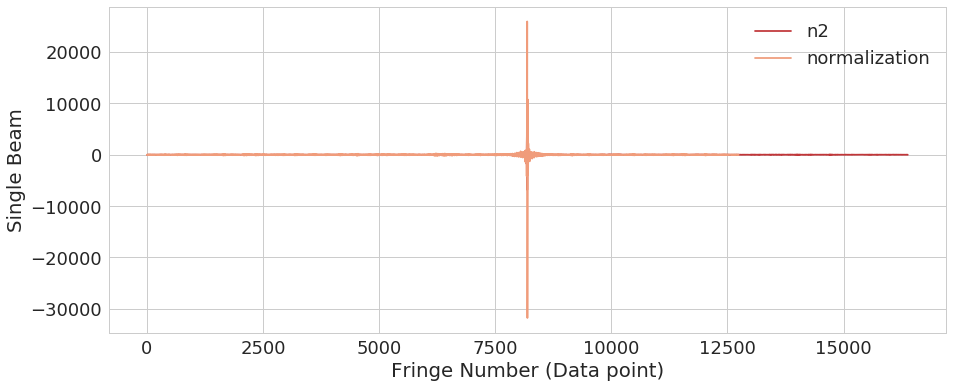

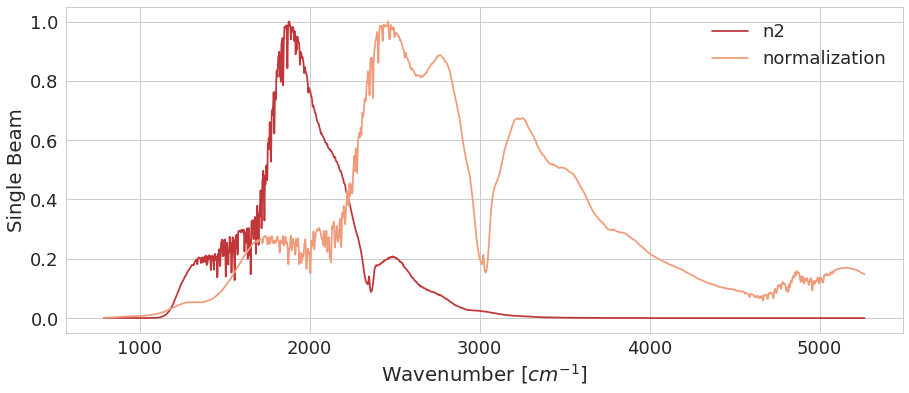

No handles with labels found to put in legend.


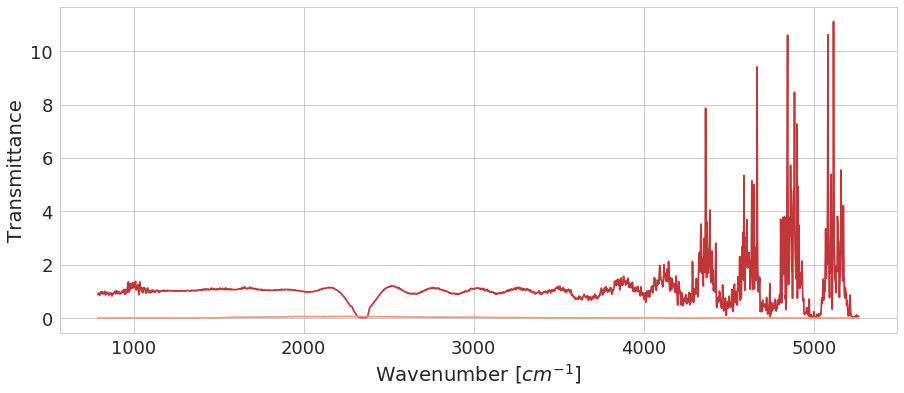

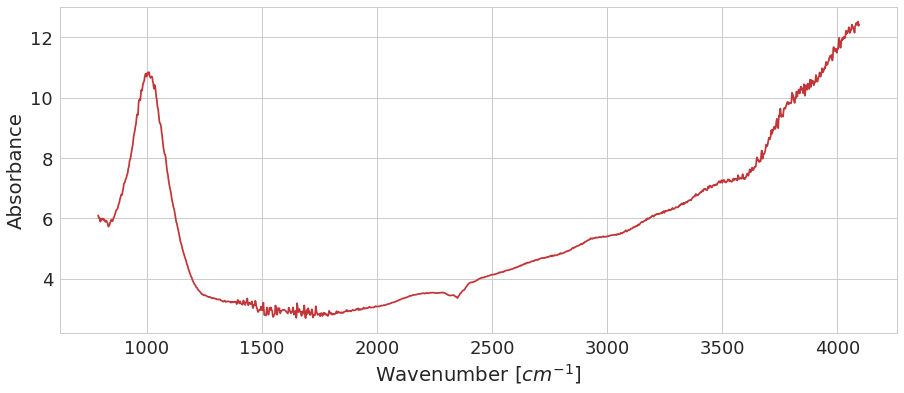

In [547]:
# Raw data interferogram
plt.figure()
plt.plot(np.linspace(0, n2.num_pts[0], num=n2.num_pts[0]), n2.raw_data[0], label="n2")
plt.plot(np.linspace(0, normalization.num_pts[0], num=normalization.num_pts[0]), normalization.raw_data[0], label="normalization")
plt.grid(True)
plt.xlabel("Fringe Number (Data point)")
plt.ylabel("Single Beam")
plt.legend()
plt.show()

# The FT'd result
plt.figure()
ind = int(len(n2.wavenumbers[0])/3)
lind = int(len(n2.wavenumbers[0])/20)
plt.plot(n2.wavenumbers[0][lind:ind], n2.spectra[0][lind:ind]/max(n2.spectra[0][lind:ind]), label="n2")

ind = int(len(normalization.wavenumbers[0])/3)
lind = int(len(normalization.wavenumbers[0])/20)
plt.plot(normalization.wavenumbers[0][lind:ind], normalization.spectra[0][lind:ind]/max(normalization.spectra[0][lind:ind]), label="normalization")
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Single Beam")
plt.legend()
plt.show()

# Transmittance
plt.figure()
i=0
ind = int(len(n2.wavenumbers[0])/3)
lind = int(len(n2.wavenumbers[0])/20)
plt.plot(n2.wavenumbers[i][lind:ind], Interferogram.calc_transmittance(n2.spectra[0][lind:ind], co2.spectra[0][lind:ind]))

ind = int(len(normalization.wavenumbers[0])/3)
lind = int(len(normalization.wavenumbers[0])/20)
plt.plot(normalization.wavenumbers[i][lind:ind], Interferogram.calc_transmittance(normalization.spectra[0][lind:ind], n2.spectra[0][lind:ind]))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Transmittance")
plt.legend()
plt.show()

# Absorbance
plt.figure()
i=0
lind = max(int(len(n2.wavenumbers[0])/20), int(len(normalization.wavenumbers[0])/20))
ind = min(int(len(normalization.wavenumbers[0])/3), int(len(n2.wavenumbers[0])/3))
plt.plot(n2.wavenumbers[i][lind:ind], Interferogram.calc_absorbance(Interferogram.calc_transmittance(normalization.spectra[0][lind:ind], n2.spectra[0][lind:ind])))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Absorbance")
plt.show()

# Step 6

In [548]:
DIR = "week2/"
filename = "Step 6/co2_cell_4cm-1 (3min).txt"
co2 = Interferogram(DIR, filename)

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


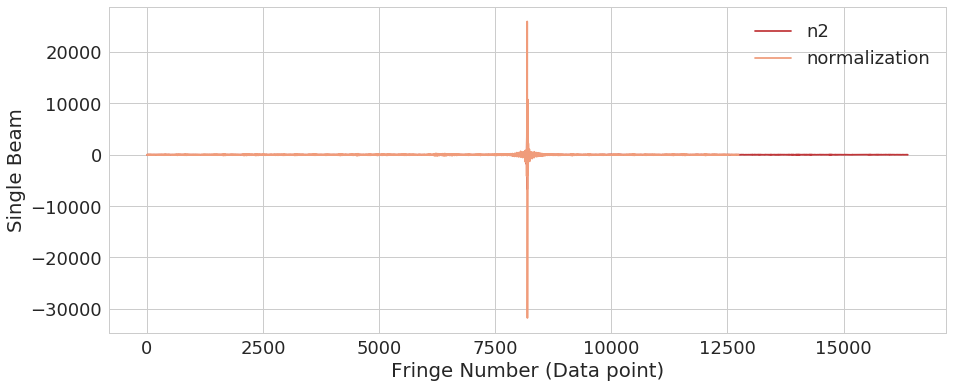

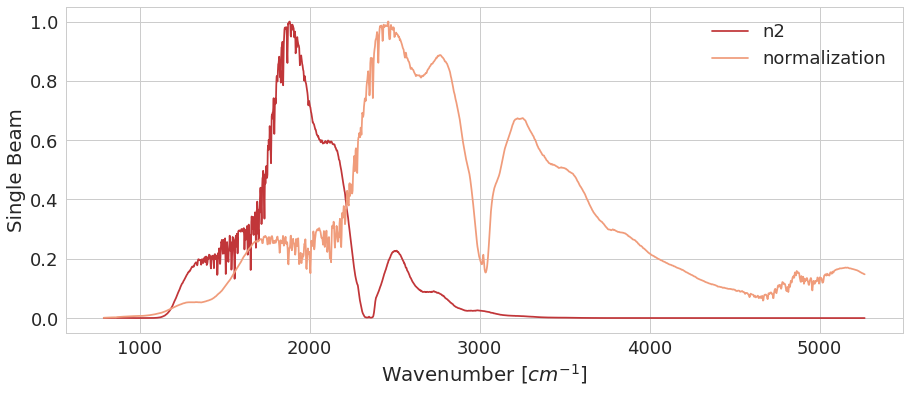

No handles with labels found to put in legend.


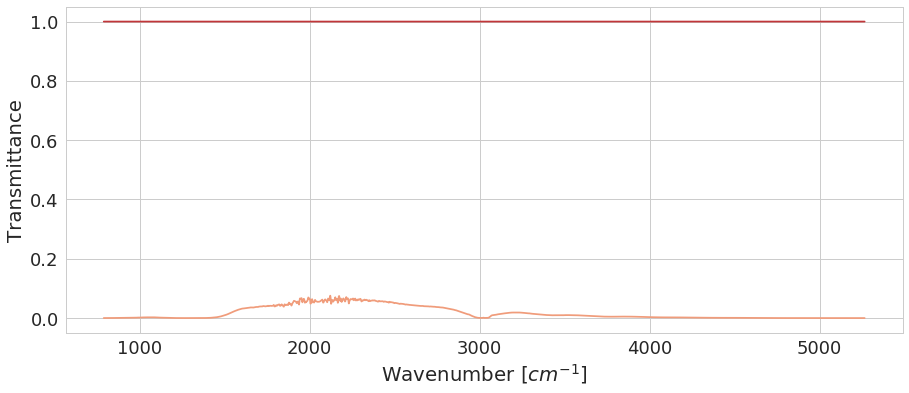

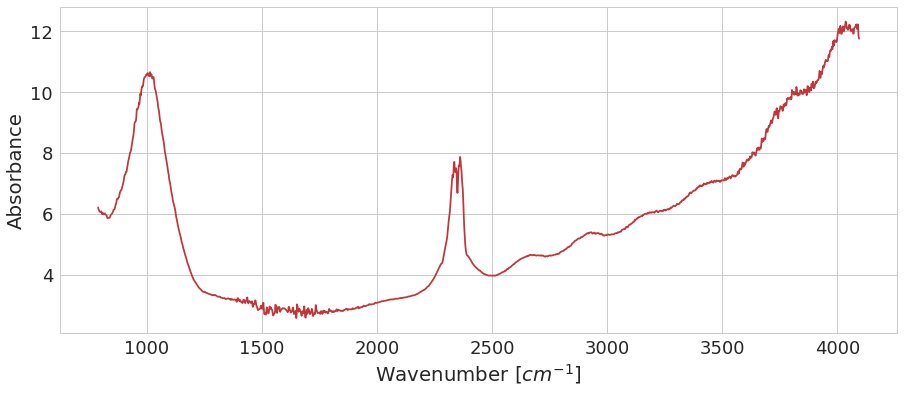

In [549]:
# Raw data interferogram
n2 = co2
plt.figure()
plt.plot(np.linspace(0, n2.num_pts[0], num=n2.num_pts[0]), n2.raw_data[0], label="n2")
plt.plot(np.linspace(0, normalization.num_pts[0], num=normalization.num_pts[0]), normalization.raw_data[0], label="normalization")
plt.grid(True)
plt.xlabel("Fringe Number (Data point)")
plt.ylabel("Single Beam")
plt.legend()
plt.show()

# The FT'd result
plt.figure()
ind = int(len(n2.wavenumbers[0])/3)
lind = int(len(n2.wavenumbers[0])/20)
plt.plot(n2.wavenumbers[0][lind:ind], n2.spectra[0][lind:ind]/max(n2.spectra[0][lind:ind]), label="n2")

ind = int(len(normalization.wavenumbers[0])/3)
lind = int(len(normalization.wavenumbers[0])/20)
plt.plot(normalization.wavenumbers[0][lind:ind], normalization.spectra[0][lind:ind]/max(normalization.spectra[0][lind:ind]), label="normalization")
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Single Beam")
plt.legend()
plt.show()

# Transmittance
plt.figure()
i=0
ind = int(len(n2.wavenumbers[0])/3)
lind = int(len(n2.wavenumbers[0])/20)
plt.plot(n2.wavenumbers[i][lind:ind], Interferogram.calc_transmittance(n2.spectra[0][lind:ind], co2.spectra[0][lind:ind]))

ind = int(len(normalization.wavenumbers[0])/3)
lind = int(len(normalization.wavenumbers[0])/20)
plt.plot(normalization.wavenumbers[i][lind:ind], Interferogram.calc_transmittance(normalization.spectra[0][lind:ind], n2.spectra[0][lind:ind]))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Transmittance")
plt.legend()
plt.show()

# Absorbance
plt.figure()
i=0
lind = max(int(len(n2.wavenumbers[0])/20), int(len(normalization.wavenumbers[0])/20))
ind = min(int(len(normalization.wavenumbers[0])/3), int(len(n2.wavenumbers[0])/3))
plt.plot(n2.wavenumbers[i][lind:ind], Interferogram.calc_absorbance(Interferogram.calc_transmittance(normalization.spectra[0][lind:ind], n2.spectra[0][lind:ind])))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Absorbance")
plt.show()

# Step 7

In [ ]:
DIR = "week2/"
filename = "Step 7/air_cell_4cm-1.txt"
air = Interferogram(DIR, filename)

/Users/linesther/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [ ]:
# Raw data interferogram
n2 = air
plt.figure()
plt.plot(np.linspace(0, n2.num_pts[0], num=n2.num_pts[0]), n2.raw_data[0], label="n2")
plt.plot(np.linspace(0, normalization.num_pts[0], num=normalization.num_pts[0]), normalization.raw_data[0], label="normalization")
plt.grid(True)
plt.xlabel("Fringe Number (Data point)")
plt.ylabel("Single Beam")
plt.legend()
plt.show()

# The FT'd result
plt.figure()
ind = int(len(n2.wavenumbers[0])/3)
lind = int(len(n2.wavenumbers[0])/20)
plt.plot(n2.wavenumbers[0][lind:ind], n2.spectra[0][lind:ind]/max(n2.spectra[0][lind:ind]), label="n2")

ind = int(len(normalization.wavenumbers[0])/3)
lind = int(len(normalization.wavenumbers[0])/20)
plt.plot(normalization.wavenumbers[0][lind:ind], normalization.spectra[0][lind:ind]/max(normalization.spectra[0][lind:ind]), label="normalization")
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Single Beam")
plt.legend()
plt.show()

# Transmittance
plt.figure()
i=0
ind = int(len(n2.wavenumbers[0])/3)
lind = int(len(n2.wavenumbers[0])/20)
plt.plot(n2.wavenumbers[i][lind:ind], Interferogram.calc_transmittance(n2.spectra[0][lind:ind], co2.spectra[0][lind:ind]))

ind = int(len(normalization.wavenumbers[0])/3)
lind = int(len(normalization.wavenumbers[0])/20)
plt.plot(normalization.wavenumbers[i][lind:ind], Interferogram.calc_transmittance(normalization.spectra[0][lind:ind], n2.spectra[0][lind:ind]))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Transmittance")
plt.legend()
plt.show()

# Absorbance
plt.figure()
i=0
lind = max(int(len(n2.wavenumbers[0])/20), int(len(normalization.wavenumbers[0])/20))
ind = min(int(len(normalization.wavenumbers[0])/3), int(len(n2.wavenumbers[0])/3))
plt.plot(n2.wavenumbers[i][lind:ind], Interferogram.calc_absorbance(Interferogram.calc_transmittance(normalization.spectra[0][lind:ind], n2.spectra[0][lind:ind])))
plt.grid(True)
plt.xlabel(r"Wavenumber [$cm^{-1}$]")
plt.ylabel("Absorbance")
plt.show()